# Sentiment Analysis and Personalized Messaging for Clinical Trial Recruitment

Installing necessary libraries

In [1]:
!pip install praw transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.2 MB/s eta 0:00:00


In [2]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [32]:
!pip install nltk

Necessary Imports

In [60]:
import praw
from praw.models import MoreComments
import pandas as pd
import time
from transformers import pipeline
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize

In [45]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Scraping/ Data Collection

In [61]:
# Setup PRAW with Reddit API credentials
reddit = praw.Reddit(
    client_id="EHSVoqAsOGZNHtnry4ACoQ",
    client_secret="D_iEQYt3Jhq_pszBiTK8ju6GeJht4Q",
    password="gyhxa8-qeqqom-Nawfuj",
    user_agent="Turmerik Task by u/browniekanya",
    username="browniekanya",
    check_for_async=False
)

In [62]:
# List of subreddits to scrape
subreddits = [
    "health", "AskDocs", "medical", "clinicalresearch", "medicine",
    "cancer", "diabetes", "MultipleSclerosis", "Epilepsy",
    "ChronicPain", "IBD", "CrohnsDisease", "UlcerativeColitis",
    "Psoriasis", "eczema", "Allergies", "Asthma", "lupus", "mentalhealth",
    "depression", "BipolarReddit", "schizophrenia", "Anxiety", "ADHD", "autism",
    "addiction", "stopsmoking", "OpiatesRecovery", "alcoholism", "stopdrinking",
    "WeightLossAdvice", "loseit", "fitness", "HealthyFood", "nutrition",
    "Supplements", "intermittentfasting", "keto", "vegan", "vegetarian",
    "GERD", "stroke", "hypertension", "Dermatology", "SkincareAddiction",
    "WomensHealth", "menshealth", "healthcare", "publichealth", "globalhealth",
    "healthIT", "TeleMedicine", "HealthInsurance", "epidemiology",
    "biology", "genetics", "Vitiligo", "Oncology", "Endo", "thyroidhealth",
    "Hemophilia", "lymedisease", "migraine", "leukemia", "Parkinsons", "ALS"
]

In [63]:
# Function to scrape data
def scrape_subreddits(subreddit_list, limit_per_subreddit=200, search_terms=None):
    if search_terms is None:
        search_terms = ["clinical trial",  "clinical study",
                        "clinical research", "drug trial", "treatment study"]
    all_posts = []
    for subreddit in subreddit_list:
        sub = reddit.subreddit(subreddit)
        for post in sub.hot(limit=limit_per_subreddit):
          if any(term.lower() in post.title.lower() or term.lower() in post.selftext.lower() for term in search_terms):
            post_dict = {
                'subreddit': subreddit,
                'title': post.title,
                'text': post.selftext,
                'id': post.id
            }
            all_posts.append(post_dict)

            # Scrape comments
            post.comments.replace_more(limit=0)
            for comment in post.comments.list():
              if any(term.lower() in comment.body.lower() for term in search_terms):
                all_posts.append({
                    'subreddit': subreddit,
                    'title': f"Comment on: {post.title}",
                    'text': comment.body,
                    'id': comment.id
                })
            time.sleep(1.1) # Sleep for slightly over 1 second between requests
    return pd.DataFrame(all_posts)

In [64]:
# Scrape data
data = scrape_subreddits(subreddits)
print("Number of posts and comments mentioning 'clinical trial':", len(data))
print(data.head())

Number of posts and comments mentioning 'clinical trial': 253
          subreddit                                              title  \
0  clinicalresearch  Clinical Research Role/Salary Master Form & Sp...   
1  clinicalresearch  Comment on: Clinical Research Role/Salary Mast...   
2  clinicalresearch  Comment on: Clinical Research Role/Salary Mast...   
3  clinicalresearch  Comment on: Clinical Research Role/Salary Mast...   
4  clinicalresearch  Comment on: Clinical Research Role/Salary Mast...   

                                                text       id  
0  **UPDATE 2023-SEP-05:**   \n*Any responses bef...   luz3vf  
1  As a graduate student in a clinical research p...  gp9n6rc  
2  Not sure if anyone is still checking in on thi...  gyjb8jy  
3  How do you get into clinical research as a beg...  gu2pcqh  
4  Academia research assistant (3 years) > entry ...  hxbdkxe  


In [65]:
# Save the data to a CSV file
data.to_csv('reddit_scraped_data.csv', index=False)

## Sentiment Analysis

In [66]:
sentiment_pipeline = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base')

In [67]:
# Function to predict emotion using the pre-trained pipeline
def predict_emotion(row):
    if row['title'].startswith("Comment on:"):
        text_to_analyze = row['text']  # Use the text for comments
    else:
        text_to_analyze = row['title']  # Use the title otherwise

    text_to_analyze = str(text_to_analyze).strip()

    if not text_to_analyze:  # Check if the text is empty
        return ("Empty", 0.0)

    words = text_to_analyze.split()
    truncated_text = " ".join(words[:min(len(words), 514)])

    try:
        results = sentiment_pipeline(truncated_text)
        return results[0]['label'], results[0]['score']
    except Exception as e:
        print(f"Error processing text: {e}")
        return ("Error", 0.0)

In [68]:
# Load the data
data = pd.read_csv('reddit_scraped_data.csv')

# Apply the sentiment analysis function
data['emotion'], data['confidence'] = zip(*data.apply(predict_emotion, axis=1))

# Print the updated DataFrame
print(data.head())

# Save the updated DataFrame to a new CSV file
data.to_csv('sentiment_analyzed_data.csv', index=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


Error processing text: The expanded size of the tensor (558) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 558].  Tensor sizes: [1, 514]
Error processing text: The expanded size of the tensor (610) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 610].  Tensor sizes: [1, 514]
          subreddit                                              title  \
0  clinicalresearch  Clinical Research Role/Salary Master Form & Sp...   
1  clinicalresearch  Comment on: Clinical Research Role/Salary Mast...   
2  clinicalresearch  Comment on: Clinical Research Role/Salary Mast...   
3  clinicalresearch  Comment on: Clinical Research Role/Salary Mast...   
4  clinicalresearch  Comment on: Clinical Research Role/Salary Mast...   

                                                text       id   emotion  \
0  **UPDATE 2023-SEP-05:**   \n*Any responses bef...   luz3vf   neutral   
1  As a graduate student in a clinical research p...  g

In [74]:
def clean_text(text):

    text = str(text)
    # Lowercase the text to ensure uniformity
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)

    # Remove all non-alphabet characters including digits
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and custom common words
    #custom_stopwords = set(stopwords.words('english') + ['would', 'could', 'ive', "i've", 'us', 'one'])
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(lemmatized)

# Apply the cleaning function to your text data
data['cleaned_text'] = data['text'].apply(clean_text)

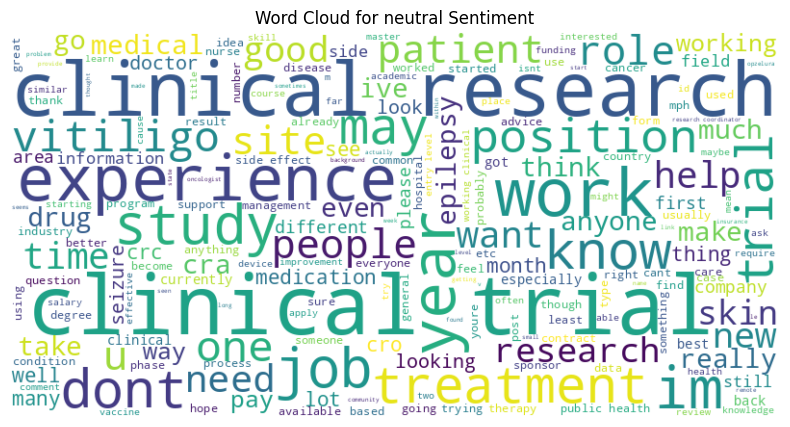

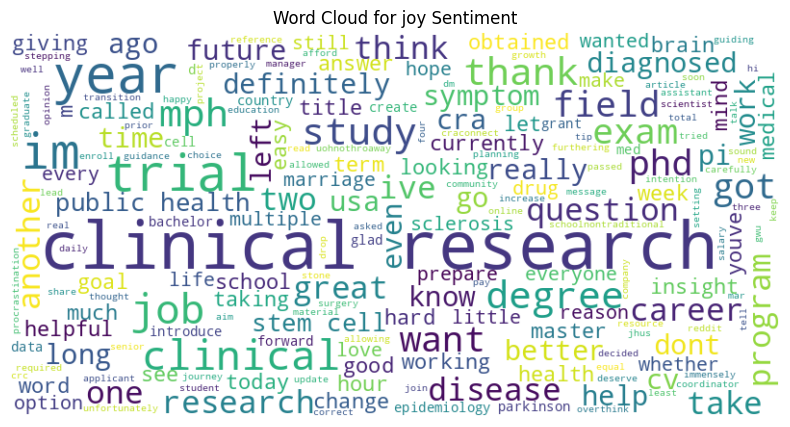

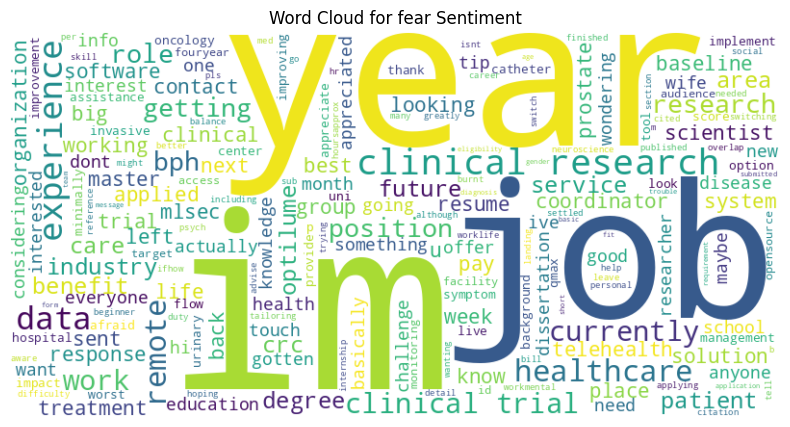

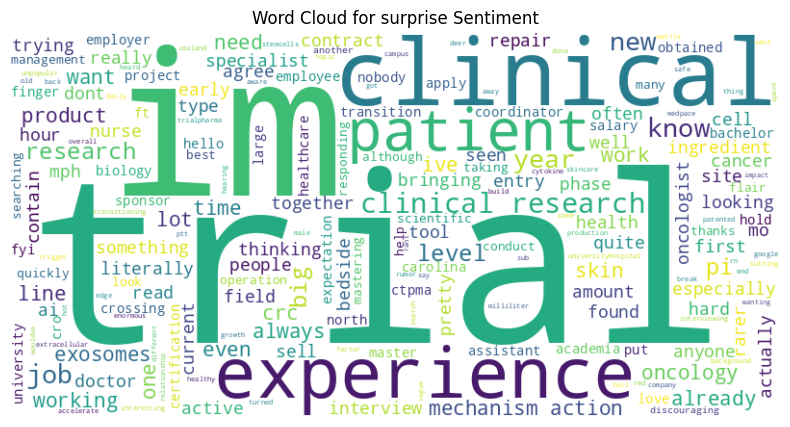

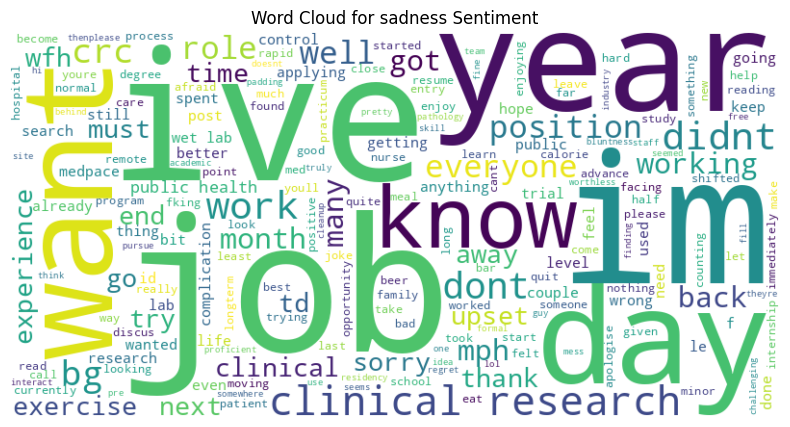

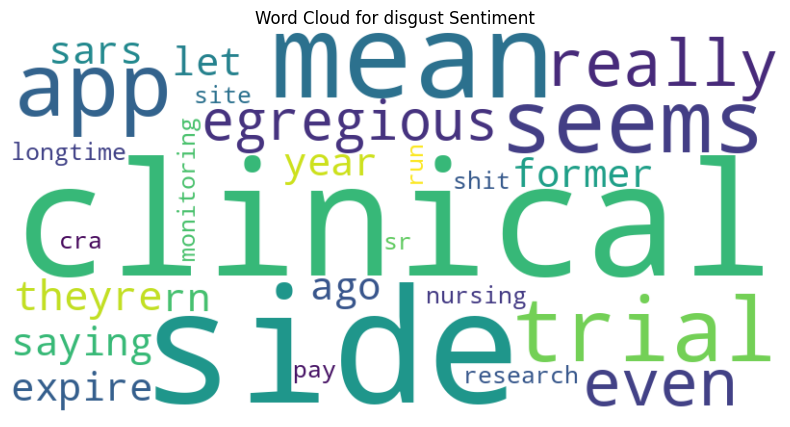

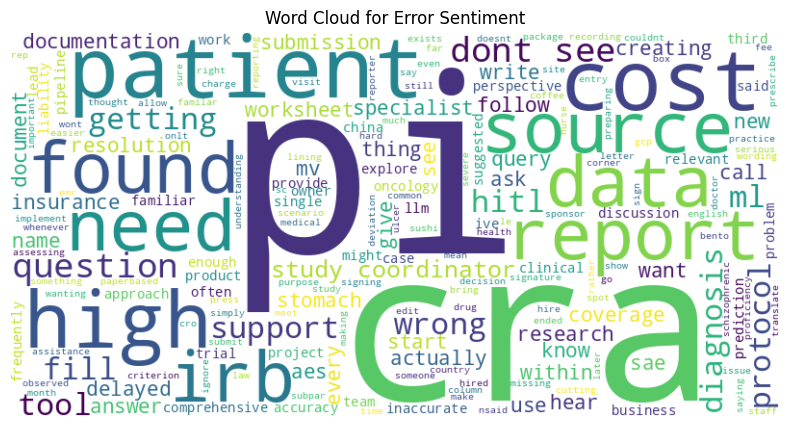

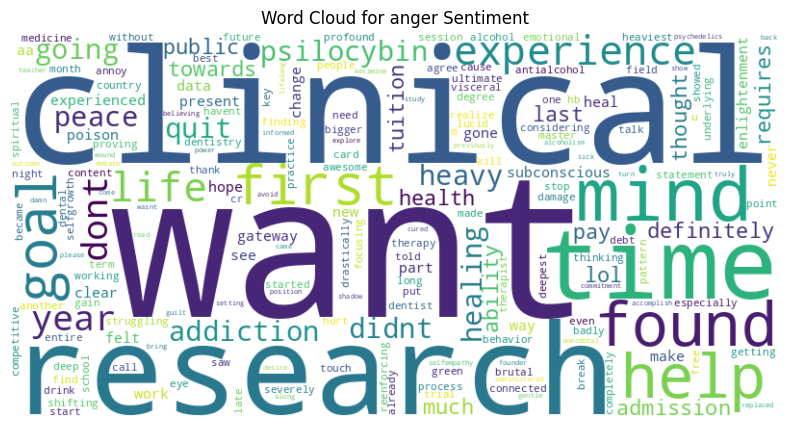

In [75]:
def generate_word_clouds_by_emotion(data):
    emotions = data['emotion'].unique()
    for emotion in emotions:
        # Filter the dataframe by emotion
        subset = data[data['emotion'] == emotion]
        text = " ".join(subset['cleaned_text'])

        # Generate a word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {emotion} Sentiment')
        plt.axis('off')
        plt.show()

# Generate word clouds for each emotion
generate_word_clouds_by_emotion(data)

In [71]:
data['emotion'].value_counts()

emotion
neutral     192
joy          19
fear         14
surprise     10
sadness      10
anger         4
disgust       2
Error         2
Name: count, dtype: int64

## Message Generation

In [95]:
# Initialize GPT-2 model and tokenizer

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side='left')
model = GPT2LMHeadModel.from_pretrained(model_name)

generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

tokenizer.pad_token = tokenizer.eos_token

In [96]:
def generate_message(emotion, key_words):
    prompt = (
        f"Given your {emotion} feelings about clinical trials and your interest in {key_words}, "
        "here is an encouraging message on why participating in a clinical trial could be beneficial:"
    )

    # Generate the message using the GPT-2 model with more constrained settings
    output = generator(prompt, max_length=150, num_return_sequences=1,
                       no_repeat_ngram_size=2, repetition_penalty=1.2,
                       temperature=0.7, top_p=0.85, do_sample=True,
                       top_k=50, pad_token_id=tokenizer.eos_token_id)

    # Extract and clean up the generated text
    generated_text = output[0]['generated_text'][len(prompt):]
    # Attempt to end at the last full sentence to avoid incomplete thoughts
    periods = [pos for pos, char in enumerate(generated_text) if char == "."]
    if periods:
        generated_text = generated_text[:periods[-1]+1]

    return generated_text.strip()

In [97]:
keywords = {
    'neutral': "research, patient, experience, clinical, treatment",
    'joy': "clinical, trial, research, career, health",
    'fear': "clinical, healthcare, job, treatment, system",
    'surprise': "clinical, research, patient, experience, job",
    'sadness': "job, research, clinical, time, work",
    'disgust': "clinical, trial, year, research",
    'anger': "clinical, research, health, help, job",
    'error': "system, support, study, error"
}

# Generating messages for each sentiment
for emotion, words in keywords.items():
    message = generate_message(emotion, words)
    print(f"Message for {emotion} sentiment: {message}\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Message for neutral sentiment: A study can help you to improve the outcome of this particular disease. If it has been shown that certain therapies are effective for reducing symptoms such as anxiety or depression but not all patients benefit from them then there may very well be other treatments out at hand which will also work equally great against those who do need their therapy (for example anti-psychotic drugs).

Message for joy sentiment: 1. You will get better results by giving up the fear of rejection or making it clear that you don't want to take any further steps forward with this endeavor! 2. If we can do something at all for our patients as opposed only trying out new treatments? 3, 4 The more I understand how important patient-centered care really has been because so many people have done nothing but accept their failures when they found themselves stuck inside another person's body – even if not completely hopeless (see http://www..thecureandhealthjournal/2013...).

Messag

In [59]:
# Load your sentiment analyzed data
data = pd.read_csv('sentiment_analyzed_data.csv')

# Generate messages based on sentiment
data['message'] = data['emotion'].apply(lambda x: generate_text(f"Based on your {x} sentiment, here's why participating in a clinical trial might be beneficial for you:"))

# Save or display results
print(data.head())
data.to_csv('final_output_with_messages.csv', index=False)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


KeyboardInterrupt: 